# Introduction 

Current results:
Mean IoU: 0.6629, Accuracy: 89.79%, Inference Time: 0.1820s  
class [0], IoU: 0.8136  
class [1], IoU: 0.0000  
class [2], IoU: 0.7180  
class [3], IoU: 0.8488  
class [4], IoU: 0.7615  
class [5], IoU: 0.8074  
class [6], IoU: 0.7995  
class [7], IoU: 0.5547  


In [64]:
"""
Class ID RGB
Other 0 0,0,0
Ball 1 255,0,0
Plate,bowl 2 0,255,0
Mug 3 0,0,255
Box* 4 0,255,255
Bottle** 5 
Drinking Glass,Cup 6 0,0,255
Can, Tin Can*** 7 255,0,255

"""

'\nObject: DF Index, IDx\nSky: 2,3\nTree: 4,5\nBuilding: 1,2\nPerson: 12,13\nRoad: 6,7\nCar: 20,21\nLight: 82,83\n'

# Set up Environment

In [1]:
import os,json,ast, csv, torch, scipy.io, PIL.Image, torchvision.transforms
import numpy as np
import pandas as pd 
# ADE20k Image Segmentation Libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)
    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    print(im_vis.shape)
    display(PIL.Image.fromarray(im_vis))

In [2]:
for idx in [3,5,2,13,7,21,83]:
    square = np.zeros((100,100,3))
    print(colors[idx].shape)
    square[:,:] = np.array([colors[idx]]).astype(np.uint8)
    display(PIL.Image.fromarray(square))

(3,)


TypeError: Cannot handle this data type

# Loading Segmentation Models

In [12]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet18dilated',
    fc_dim=512,
    weights='ckpt/ade20k-resnet18dilated-ppm_deepsup-limited/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=512,
    num_class=7,
    weights='ckpt/ade20k-resnet18dilated-ppm_deepsup-limited/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SynchronizedBatch

# Load Example Test Images

In [4]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('./data/ADEChallengeData2016/images/training/ADE_train_00000314.jpg').convert('RGB')
seg_image = PIL.Image.open('./data/ADEChallengeData2016/annotations/training/ADE_train_00000314.png')
img_original = np.array(pil_image)
seg_data = np.array(seg_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

In [5]:
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

NameError: name 'segmentation_module' is not defined

In [20]:
print(np.unique(pred))

[0 3 5]


In [16]:
print(np.unique(seg_data))

[  0   2   3   5   7  13 103]


In [ ]:
"""
Object: DF Index, IDx
Sky: 2,3
Tree: 4,5
Building: 1,2
Person: 12,13
Road: 6,7
Car: 20,21
Light: 82,83
"""

# DeepLabV3 

In [9]:
import importlib
import deeplab_model
importlib.reload(deeplab_model.deeplabv3)

<module 'deeplab_model.deeplabv3' from 'C:\\Users\\hturner\\Documents\\Projects\\BinaryImageSegmentation\\deeplab_model\\deeplabv3.py'>

In [8]:
from deeplab_model.deeplabv3 import DeepLabV3
net = DeepLabV3(num_classes=150)

In [10]:
print(img_data.shape)
print(img_data)

torch.Size([3, 512, 768])
tensor([[[ 0.5193, -0.1657, -1.2274,  ...,  1.0502,  1.0502,  1.0502],
         [ 0.3138,  0.5022,  0.4166,  ...,  1.0673,  1.0502,  1.0502],
         [ 0.4166,  0.4337,  0.6563,  ...,  1.0673,  1.0673,  1.0502],
         ...,
         [-0.2513, -0.4054, -0.5082,  ...,  0.7591,  0.7762,  0.7077],
         [-0.7479, -0.6109, -0.5424,  ...,  0.7762,  0.7248,  0.6734],
         [-1.0733, -0.7137, -0.6452,  ...,  0.7419,  0.7077,  0.6563]],

        [[ 0.3452, -0.3550, -1.4230,  ...,  1.2031,  1.2031,  1.2031],
         [ 0.1527,  0.3452,  0.2577,  ...,  1.2206,  1.2031,  1.2031],
         [ 0.2577,  0.2752,  0.5028,  ...,  1.2206,  1.2206,  1.2031],
         ...,
         [ 0.2927,  0.1352, -0.0049,  ...,  0.5028,  0.5203,  0.5028],
         [-0.1800, -0.0749, -0.0399,  ...,  0.5203,  0.5203,  0.4678],
         [-0.5126, -0.1450, -0.0924,  ...,  0.5378,  0.5028,  0.4503]],

        [[ 0.4962, -0.2010, -1.3164,  ...,  1.3851,  1.3851,  1.3851],
         [ 0.2522, 

torch.Size([1, 256, 32, 48])


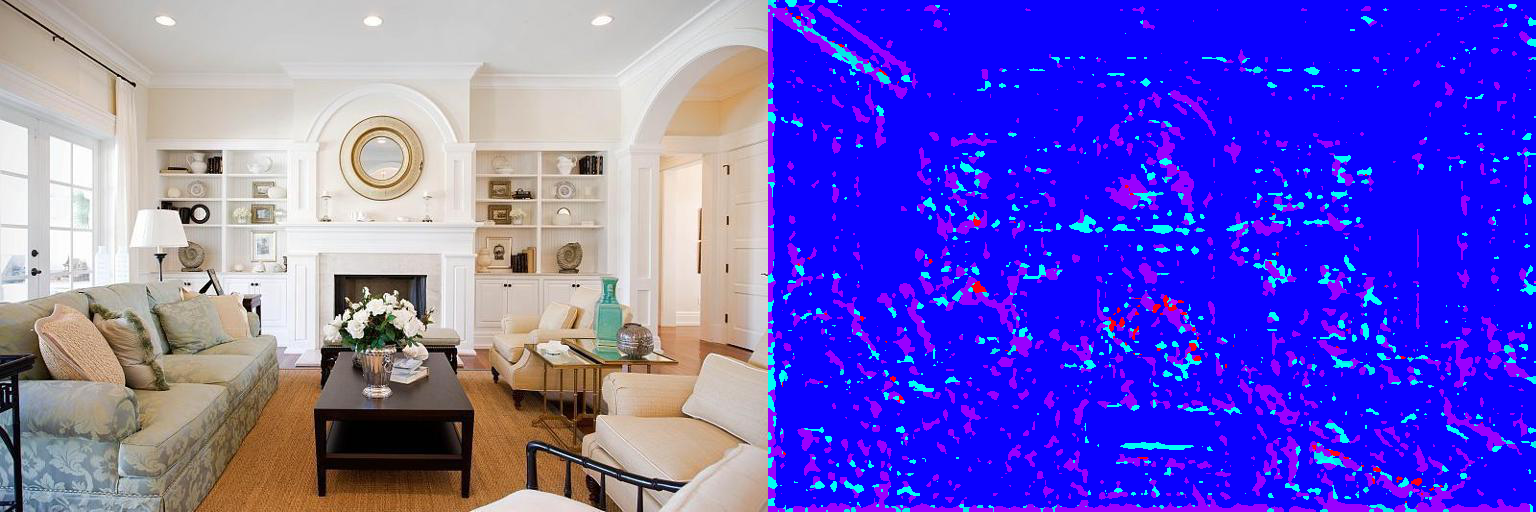

In [48]:
net.eval()
with torch.no_grad():
    output = net(img_data[None])
_, pred = torch.max(output, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

# Parse Dataset

In [23]:
object_data = pd.read_csv("./data/object150_info.csv")

In [37]:
object_data.sort_values(by=['Name'],ascending=True).head(80)

,Idx,Ratio,Train,Val,Stuff,Name
90,91,0.0007,135,12,0,airplane;aeroplane;plane
126,127,0.0004,97,23,0,animal;animate;being;beast;brute;creature;fauna
92,93,0.0007,178,17,0,apparel;wearing;apparel;dress;clothes
78,79,0.0009,68,6,0,arcade;machine
30,31,0.0044,1172,98,0,armchair
138,139,0.0003,671,100,0,ashcan;trash;can;garbage;can;wastebin;ash;bin;...
86,87,0.0007,533,61,0,awning;sunshade;sunblind
115,116,0.0005,531,72,0,bag
119,120,0.0005,136,25,0,ball
95,96,0.0006,452,50,0,bannister;banister;balustrade;balusters;handrail


In [39]:
object_data.loc[object_data['Name'].str.contains("cup")]

,Idx,Ratio,Train,Val,Stuff,Name


In [8]:
"""
Object: DF Index, IDx, Train, Val
Ball: 119, 120, 136, 25
Plate: 142, 143, 570, 59
Bottle: 98, 99 , 965, 114
Box: 41,42, 1440, 162
Glass(Drinking glass): 147,148, 504, 57
"""
included_classes = {'Ball':120, 'Plate':143, 'Box':13,'Glass':7,'Bottle':21}

In [ ]:
"""Background classes:
Wall: 1, 11664, 1172
Building: 2,6056,612
Sky: 3. 8265, 796
Floor: 4, 9336,917
Ceiling: 6, 6604, 643
earth,ground: 14, 1804, 190


"""

In [9]:
def checkImage(path):
    labels = np.array(PIL.Image.open("./data/" + path))
    for idx in included_classes.values():
        if idx in labels:
            return True
    return False

In [1]:
def checkImage2(path):
    labels = np.array(PIL.Image.open("./data/" + path))
    if 2 in labels:
        return True
    return False

In [3]:
def makeODGT(img_list,target_path):
    with open('./data/' + target_path,'w+') as f:
        for img_data in img_list:
            f.write(json.dumps(img_data) + "\n")

In [115]:
with open('./data/training.odgt', 'r+') as f:
    train_data = f.readlines()
with open('./data/validation.odgt', 'r+') as f:
    val_data = f.readlines()

In [39]:
test_image = np.array(PIL.Image.open("./data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png"))
print(np.min(test_image))

0


In [10]:
json.loads(train_data[0])

{'fpath_img': 'ADEChallengeData2016/images/training/ADE_train_00000001.jpg',
 'fpath_segm': 'ADEChallengeData2016/annotations/training/ADE_train_00000001.png',
 'width': 683,
 'height': 512}

In [116]:
limited_train_data = []
excluded = 0
for data in train_data:
    if checkImage(json.loads(data)['fpath_segm']):
        limited_train_data.append(json.loads(data))
    else:
        excluded+=1
#TEST
print((excluded+len(limited_train_data))==len(train_data))

True


In [117]:
limited_val_data = []
val_excluded = 0
for data in val_data:
    if checkImage(json.loads(data)['fpath_segm']):
        limited_val_data.append(json.loads(data))
    else:
        val_excluded+=1
#TEST
print((val_excluded+len(limited_val_data))==len(val_data))

True


In [118]:
makeODGT(limited_train_data,'limited_train.odgt')
makeODGT(limited_val_data,'limited_val.odgt')

In [119]:
print(len(limited_train_data))
print(len(limited_val_data))

8207
849


# Create drake mixed dataset

In [4]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
test_mask = np.load("./data/DrakeData/data/1_00001_1_mask.npy")
print(np.unique(test_mask))

[0 2 4 5]


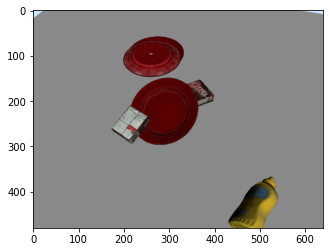

In [25]:
test_img = img.imread("./data/DrakeData/data/1_00001_1.png")
plt.imshow(test_img)

In [28]:
included_classes = {'Ball':120, 'Plate':143, 'Box':13,'Glass':7,'Bottle':21}

In [129]:
def convertToPng(filename):
    segm = np.squeeze(np.load('./data/DrakeData/data_w_backgrounds/' + filename))
    name = filename.split(".")[0]
    idx = [1,120, 143,1, 99, 42, 148]
    for i in range(len(idx)):
        segm = np.where(segm == i,idx[i],segm)
#     g = np.zeros(segm.shape)
#     b = segm.copy()
#     segm = np.squeeze(np.stack((segm,g,b),axis=2))
    segm_png = Image.fromarray(segm,'L')
#     print(segm_png.mode)
    segm_png.save('./data/ADEChallengeData2016/annotations/training/' + name + ".png")

def saveToADE20k(filename):
    im = Image.open('./data/DrakeData/data_w_backgrounds/' + filename)
    name = filename.split(".")[0]
    im_jpg = im.convert("RGB")
    im_jpg.save('./data/ADEChallengeData2016/images/training/' + name + ".jpg")
    
def makeJson(filename):
    """ {'fpath_img': 'ADEChallengeData2016/images/training/ADE_train_00000001.jpg',
 'fpath_segm': 'ADEChallengeData2016/annotations/training/ADE_train_00000001.png',
 'width': 683,
 'height': 512}"""
    im = Image.open('./data/ADEChallengeData2016/images/training/' + filename)
    width, height = im.size
    img_string = '{"fpath_img": "ADEChallengeData2016/images/training/' + filename + '"'
    segm_string = '"fpath_segm":"ADEChallengeData2016/annotations/training/' + filename[:-4] + '_mask.png"'
    width_string = '"width":' + str(width)
    height_string = '"height":' + str(height)
    json_data = img_string + "," + segm_string + "," + width_string + "," + height_string + '}'
#     print(json_data)
#     print(len(json_data))
    return json.loads(json_data)
def makeODGT(img_list,target_path):
    with open('./data/' + target_path,'w+') as f:
        for img_data in img_list:
            f.write(json.dumps(img_data) + "\n")

In [120]:
print(len(os.listdir('./data/DrakeData/data')))

4320


In [131]:
test_images = []

In [132]:
for filename in os.listdir('./data/DrakeData/data_w_backgrounds/'):
    if ".DS_Store" in filename:
        continue
    if ".npy" in filename:
        convertToPng(filename)
    else:
        test_images.append(filename)
        saveToADE20k(filename)

In [122]:
synthetic_train_data = []
synthetic_excluded = 0
for data in train_data:
    if checkImage(json.loads(data)['fpath_segm']):
        synthetic_train_data.append(json.loads(data))
    else:
        synthetic_excluded+=1
#TEST
print((synthetic_excluded+len(synthetic_train_data))==len(train_data))

True


In [133]:
print(len(synthetic_train_data))
print(synthetic_excluded)

10457
12003


In [134]:
for filename in test_images:
    if "ADE" not in filename:
        synthetic_train_data.append(makeJson(filename[:-4] + ".jpg"))
        

In [135]:
print(len(synthetic_train_data))

12617


In [136]:
makeODGT(synthetic_train_data,'syntheticbackground_train.odgt')

# Graphs

## Resnet18

In [155]:
points = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet18dilated-ppm_deepsup-synthetic-background/history_epoch_" + str(i) + ".pth")
    points.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points2 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet18dilated-ppm_deepsup-synthetic/history_epoch_" + str(i) + ".pth")
    points2.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points3 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet18dilated-ppm_deepsup-limited/history_epoch_" + str(i) + ".pth")
    points3.append(sum(hist['train']['acc'])/len(hist['train']['acc']))


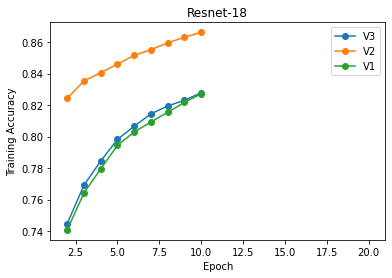

In [156]:
# plt.figure(figsize=(12,8))
plt.title("Resnet-18")
plt.plot(range(2,11),points,'-o', label="V3")
plt.plot(range(2,11),points2,'-o', label="V2")
plt.plot(range(2,11),points3,'-o', label="V1")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.xlim(1,21)
plt.legend()

In [149]:
points = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet50dilated-ppm_deepsup-limited-synthetic-background/history_epoch_" + str(i) + ".pth")
    points.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points2 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet50dilated-ppm_deepsup-limited-synthetic/history_epoch_" + str(i) + ".pth")
    points2.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points3 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-resnet50dilated-ppm_deepsup-limited/history_epoch_" + str(i) + ".pth")
    points3.append(sum(hist['train']['acc'])/len(hist['train']['acc']))


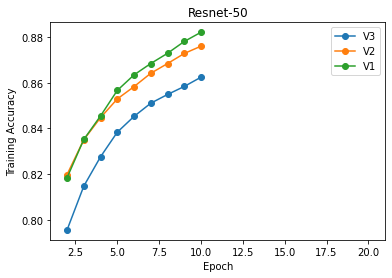

In [150]:
# plt.figure(figsize=(12,8))
plt.title("Resnet-50")
plt.plot(range(2,11),points,'-o', label="V3")
plt.plot(range(2,11),points2,'-o', label="V2")
plt.plot(range(2,11),points3,'-o', label="V1")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.xlim(1,21)
plt.legend()

In [151]:
points = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-mobilenetv2dilated-c1_deepsup/history_epoch_" + str(i) + ".pth")
    points.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points2 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-mobilenetv2dilated-c1_deepsup-synthetic/history_epoch_" + str(i) + ".pth")
    points2.append(sum(hist['train']['acc'])/len(hist['train']['acc']))
points3 = []
for i in range(2,11):
    hist = torch.load("ckpt/ade20k-mobilenetv2dilated-c1_deepsup-synthetic-background/history_epoch_" + str(i) + ".pth")
    points3.append(sum(hist['train']['acc'])/len(hist['train']['acc']))


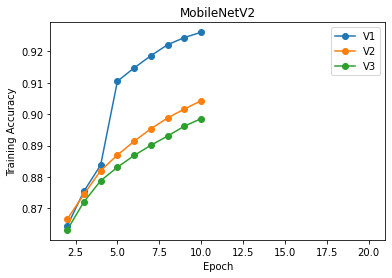

In [152]:
# plt.figure(figsize=(12,8))
plt.title("MobileNetV2")
plt.plot(range(2,11),points,'-o', label="V1")
plt.plot(range(2,11),points2,'-o', label="V2")
plt.plot(range(2,11),points3,'-o', label="V3")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.xlim(1,21)
plt.legend()

| Encoder      | Mean IOU | Dice Score | Pixel Accuracy | Inference Speed |
|--------------|----------|------------|----------------|-----------------|
| Resnet-18 V1 | .6732    | .5675      | 85.63%         | .0978s          |
| Resnet-18 V2 | .6875    | .5720      | 87.28%         | .0945s          |
| Resnet-18 V3 | 0.6243   | .5419      | 84.99%         | .0984s          |
| Resnet-50 V1 | .7721    | .5854      | 88.66%         | .1829s          |
| Resnet-50 V2 | .7297    | .5886      | 88.56%         | .1833s          |
| Resnet-50 V3 | .6984    | .5764      | 87.92%         | .1848s          |
| MobileNet V1 | .7155    | .5828      | 88.60%         | .0397s          |
| MobileNet V2 | .7350    | .5905      | 89.02%         | .0420s          |
| MobileNet V3 | .6602    | .5583      | 84.18%         | .0443s          |